In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar  8 23:07:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b06bc0ecfeabb60f2d013eaac474c14902cc813dfa1a9b6035b7e276c58f31f5
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [1]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import sys
sys.path.insert(0,'/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/')  #Root folder
sys.path.insert(0,'/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/utils/') # Libraries folder

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl

from utils import map_vis_without_lanelet

from sklearn.preprocessing import MinMaxScaler

# EXPERIMENT PARAMETERS
in_timesteps = 10
out_timesteps = 10
in_features = 5
out_features = 2

meta_features = 3 # "case_id","object_id","cluster_id"

total_features = in_features + meta_features # because we need to keep object_id features and other identifiers
total_timesteps = in_timesteps + out_timesteps

# Run name
wandb_project_name = "intersection-motion-prediction"

train_dataset_path = "/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/50m/50m-6c-train.csv"
test_dataset_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/DR_USA_Intersection_MA/50m/50m-6c-test.csv'

scaler_x_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/models/50m-6c-baseline/scaler_x.pkl'
scaler_y_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/models/50m-6c-baseline/scaler_y.pkl'

model_save_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/models/50m-6c-baseline/'
model_reload_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/models/50m-6c-baseline/'

csv_out_path = '/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/models/50m-6c-baseline/'

map_path = "/content/drive/Othercomputers/My Laptop/github-repositories/GNN-trajectory-prediction-2023/data/maps/DR_USA_Intersection_MA.osm"




**METRICS**

In [3]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE

# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    ade = []
    fde = [] 

    for r, g in zip(results, ground):
        a,f = average_displacement_error(r,g)
        ade.append(a)
        fde.append(f)
    
    return np.sum(ade)/len(ade), np.sum(fde)/len(fde)


In [4]:
def scale_3D_array(x, scaler_path, scaler_reload = True, inverse_transform = False):
   
    shape = x.shape
   
    x = x.reshape(-1, shape[2])
    
    features = x[:,meta_features:]
    meta = x[:,0:meta_features]
    
    if scaler_reload is True: # if this is test set
        scaler = pd.read_pickle(scaler_path)
    else:
        scaler = MinMaxScaler()
  
    if inverse_transform is True:
        features = scaler.inverse_transform(features)
    else:
        features = scaler.fit_transform(features)

    x  = np.concatenate((meta,features),axis=1)
    x = x.reshape(shape[0],shape[1],shape[2])

    if scaler_reload is False:  # if this is training set save scaler to file
        # Save scaler to file
        with open(scaler_path, "wb") as outfile:
            pkl.dump(scaler, outfile)

    return x

In [5]:
def load_data(dataset_path):
    # Load clustered dataset
    dataframe = pd.read_csv(test_dataset_path, sep=',')

    # This is the train dataframe without normalization, it will be needed after to write the results to disk .csv
    dataframe.drop(columns=['frame_id'],inplace=True)

    # Works if all trajectories have the same length and each cluster has the same number of vehicles
    # Convert from 2D to 3D representation (3D for LSTM)
    dataframe = dataframe.to_numpy().reshape(-1,total_timesteps,total_features)

    # Split the ground truth and the input
    x_train =  dataframe[:,0:10,:]
    y_train  = dataframe[:,10:,:]

    return x_train, y_train

In [15]:
def write_results(x,r,file_name="results.csv",columns=['case_id','object_id','cluster_id','x','y','vx','vy','psi_rad']):
    trajectories = np.concatenate((x,r),axis=1)
    trajectories = trajectories.reshape(-1,trajectories.shape[2])
    
    df = pd.DataFrame(data = trajectories, columns = columns)

    df.case_id = df.case_id.astype('int64')
    df.object_id = df.object_id.astype('int64')
    df.cluster_id = df.cluster_id.astype('int64')

    # Dummy values
    df['vx'] = 0
    df['vy'] = 0
    df['psi_rad'] = 0
    
    df_xy = df  # Return the dataframe with zeroes in vx,vy,psi_rad, required by print functions

    # write only x,y features to output file
    df_xy.drop(columns=['vx','vy','psi_rad'], inplace=True)
    df_xy.to_csv(csv_out_path + file_name,  index = False)

    return df

In [7]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project=wandb_project_name)

#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**START**

In [35]:
# Load clustered dataset and split the ground truth and the input
x_train, y_train = load_data(train_dataset_path)

In [25]:
x_train_scaled = scale_3D_array(x_train, scaler_x_path, scaler_reload = False) # don't reload the scaler from file
y_train_scaled = scale_3D_array(y_train, scaler_y_path, scaler_reload = False)

In [41]:
# Reverse normalization
#a = scale_3D_array(x_train_scaled, scaler_x_path, inverse_transform = True)
#b = scale_3D_array(y_train_scaled, scaler_y_path, inverse_transform = True)

In [ ]:
#print(np.allclose(b,y_train))

In [ ]:
#from sklearn.utils import shuffle
# Shuffle the dataset, but only on the first axis
#x_train_scaled, y_train_scaled = shuffle(x_train_scaled, y_train_scaled, random_state=1)

In [18]:
def print_trajectory_set(in_seq,gt_seq,result_seq, start, show_map = False, zoom_map = True, debug=None):
    
    fig, ax = plt.subplots(3,3,figsize=(40,5))
    fig.set_size_inches(50, 50)
    
    index = start

    for i in range(0,3):
        for j in range(0,3):
            ax[i, j] = print_trajectory(in_seq, gt_seq, result_seq, index, show_map = show_map, zoom_map = zoom_map, debug=debug, ax=ax[i,j])
            index = index + 1

    plt.show()



def print_trajectory(in_seq, gt_seq, result_seq, i, show_map = False, zoom_map = True, debug=None, ax=None):
 
    if(ax is None):
        fig, ax = plt.subplots(figsize=(40,5))
        
    object_id = in_seq[i,0,1]
  
    in_seq = in_seq[i,:,meta_features:meta_features+2]
    in_seq = np.squeeze(in_seq)
    in_seq_x = in_seq[:,0]
    in_seq_y = in_seq[:,1]

    gt_seq = gt_seq[i,:,meta_features:meta_features+2]
    gt_seq = np.squeeze(gt_seq)
    gt_seq_x = gt_seq[:,0]
    gt_seq_y = gt_seq[:,1]

    # x_coord and y_coord will be useful to calculate limit range of the map
    x_coord = np.concatenate((in_seq_x,gt_seq_x),axis=0) # join all xs
    y_coord = np.concatenate((in_seq_y,gt_seq_y),axis=0) # join all ys


    if (debug):
        print("input:\n",in_seq)
        print("truth:\n", gt_seq)    

    ax.set_aspect('equal')

    # Display map using library provided without lanelet lib
    if (show_map == True):
        map_vis_without_lanelet.draw_map_without_lanelet(map_path, ax, 0.0, 0.0)

    ax.plot(in_seq_x, in_seq_y, '-o', color='gray',linewidth=1,zorder=100)
    ax.plot(gt_seq_x, gt_seq_y, '-o', color='goldenrod',linewidth=1,zorder=100)


    if(result_seq is not None):
        result_seq = result_seq[i,:, meta_features:meta_features+2] # meta_features:meta_features+2 = position of x,y features
        result_seq = np.squeeze(result_seq)
        result_seq_x = result_seq[:,0]
        result_seq_y = result_seq[:,1]

        if(debug):
            print("forecasted:\n", result_seq)

        ax.plot(result_seq_x, result_seq_y,'-o',color='red', linewidth=1, zorder=100)
        print("object[",object_id ,"] ADE(m), FDE(m): ", average_displacement_error(result_seq,gt_seq)) # Difference between predicted and ground truth

        # Join the r results to have a true zoom range
        x_coord = np.concatenate((x_coord,result_seq_x),axis=0) # join all xs
        y_coord = np.concatenate((y_coord,result_seq_y),axis=0) # join all ys
    else:
        # Print objects' id
        print("object[",object_id ,"]")


    # Limit the visible area of the plot
    if( zoom_map == True):

        # Calculate maxs and mins
        max_x = np.amax(x_coord)
        min_x = np.amin(x_coord)
        max_y = np.amax(y_coord)
        min_y = np.amin(y_coord)
            
        # Set limits
        ax.set_xlim([min_x -10 , max_x + 10])
        ax.set_ylim([min_y -10 , max_y + 10])

    if(ax is None):
        plt.show()

    return ax

object[ 174.0 ]
object[ 177.0 ]
object[ 178.0 ]
object[ 179.0 ]
object[ 181.0 ]
object[ 182.0 ]
object[ 350.0 ]
object[ 353.0 ]
object[ 354.0 ]


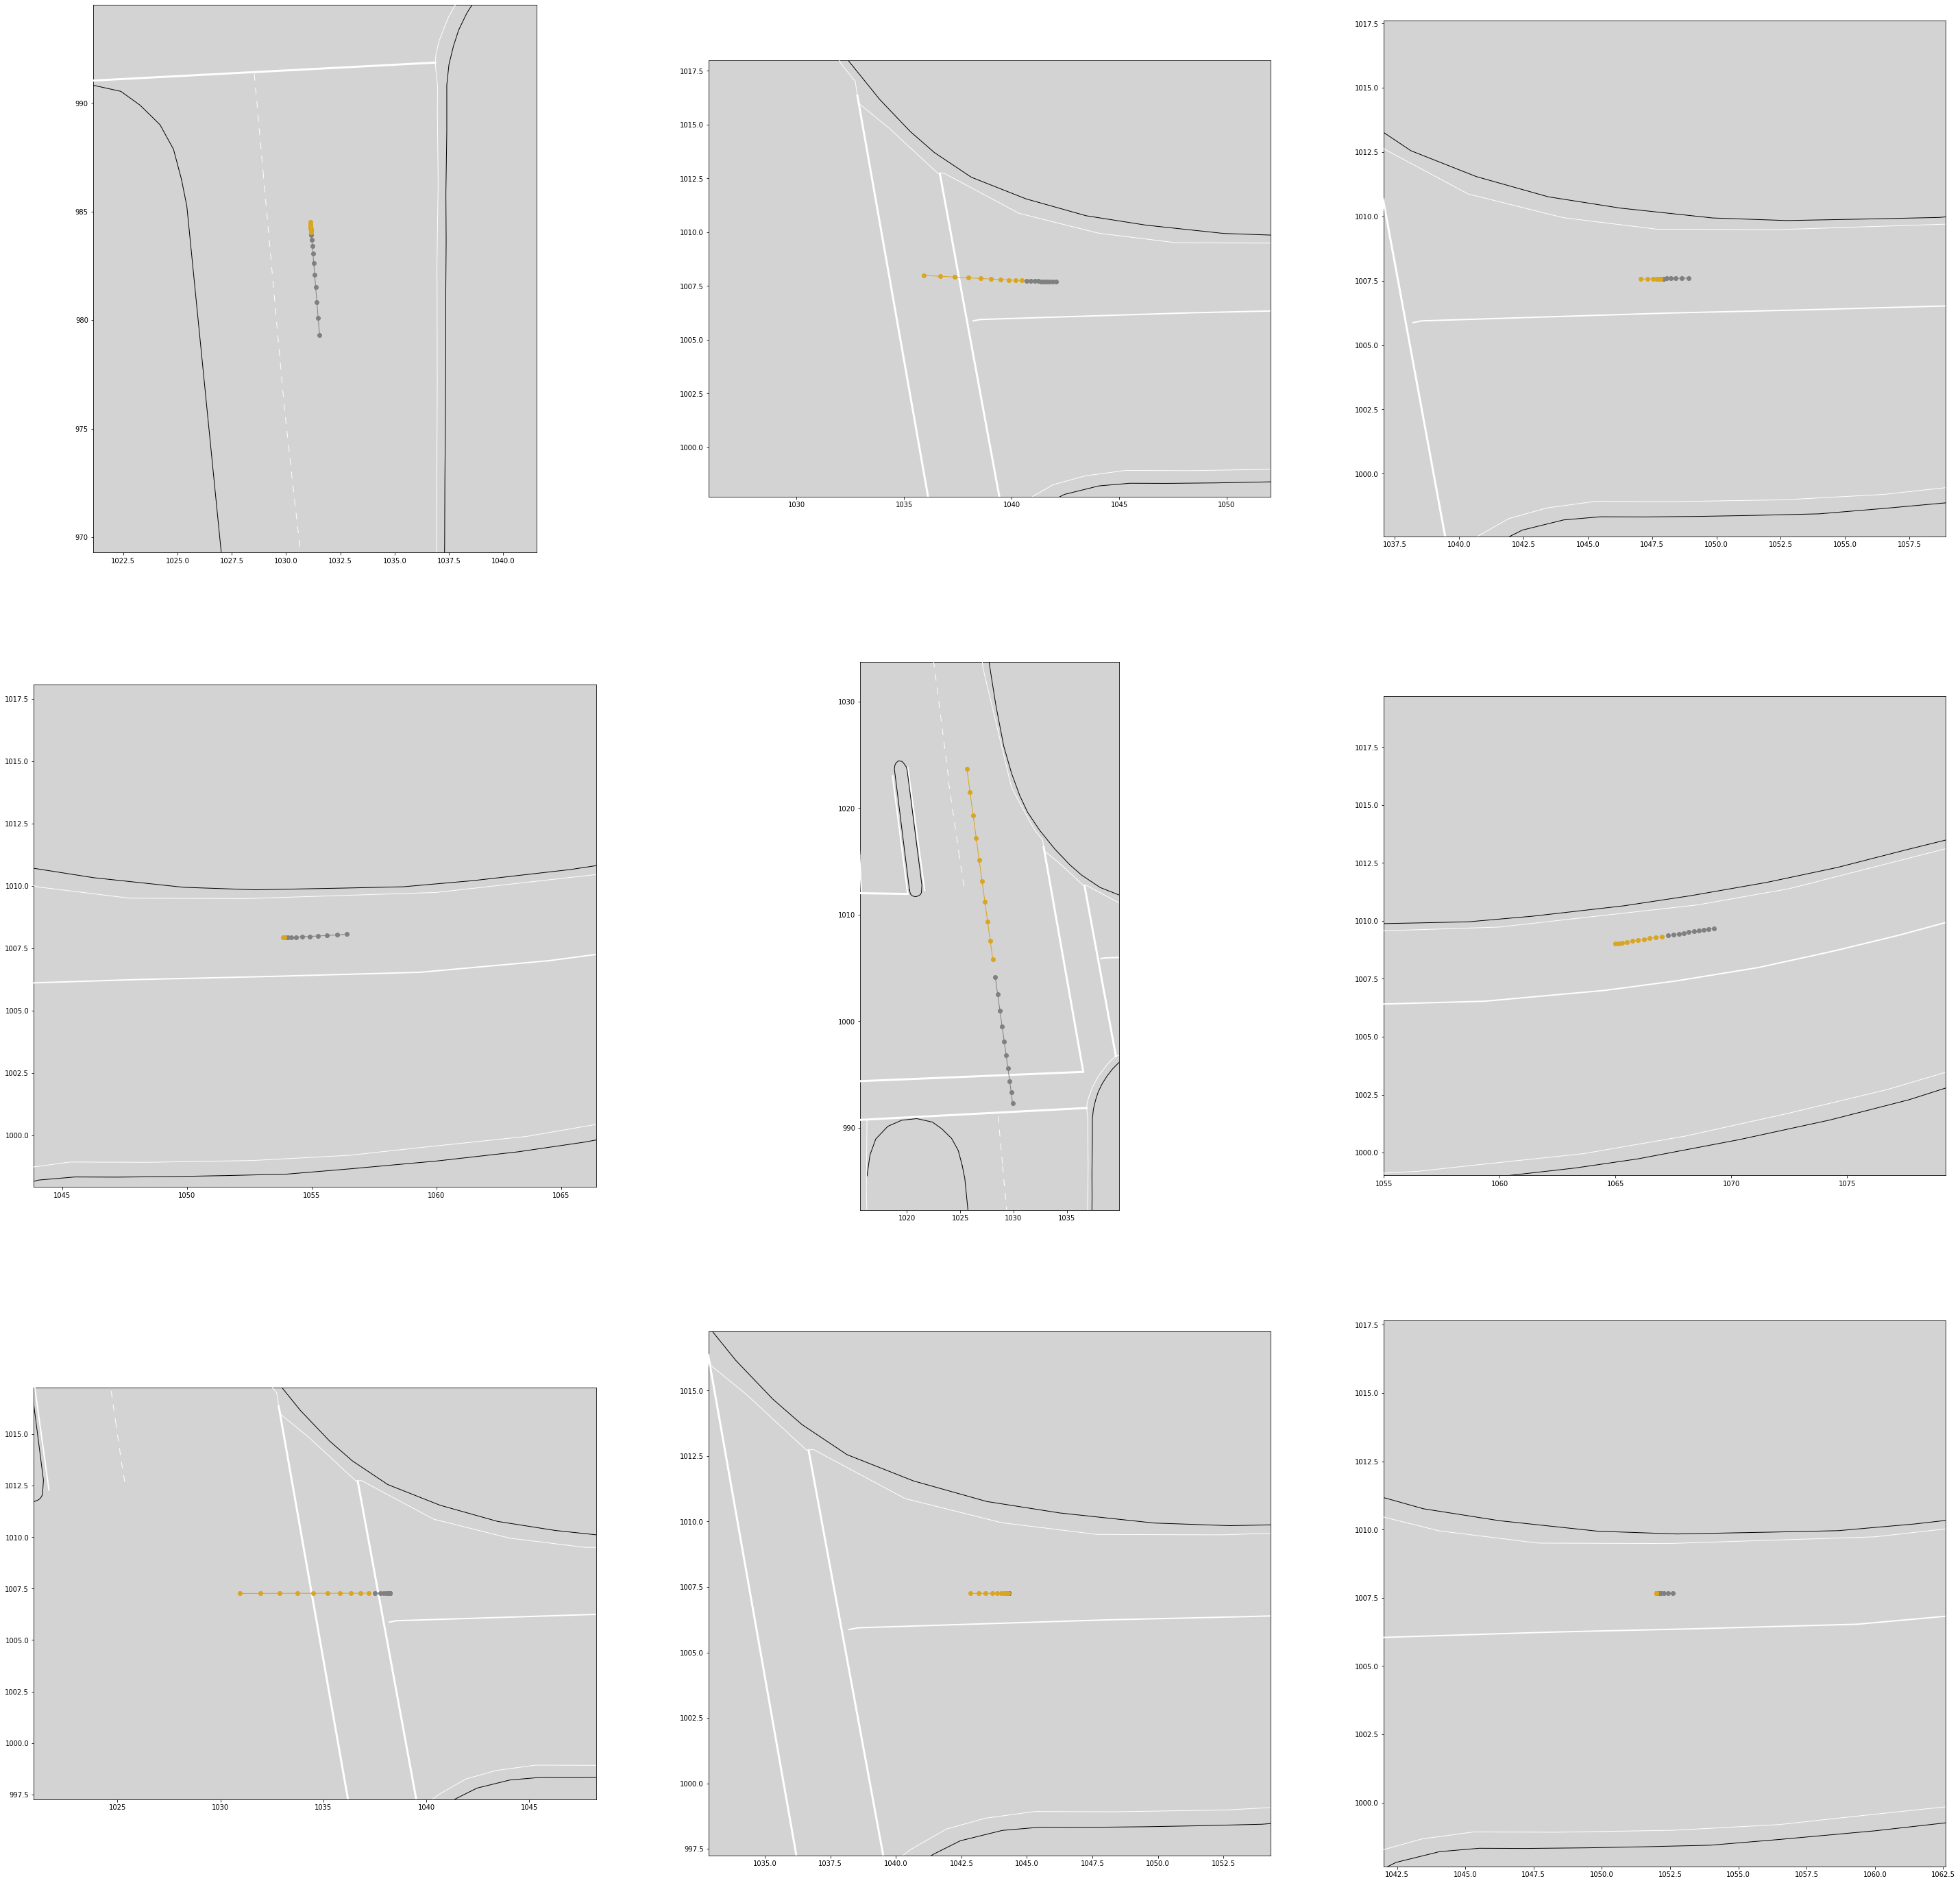

In [66]:
#print_trajectory_set(x_train[:,:,:], y_train[:,:,:],y_train[:,:,3:5],0,show_map=True, zoom_map=True,debug=False)
print_trajectory_set(x_train[:,:,:], y_train[:,:,:],None,0,show_map=True, zoom_map=True,debug=False)

object[ 174.0 ]


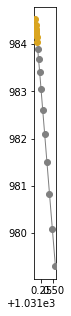

In [11]:
#print_trajectory(x_train[:,:,:], y_train[:,:,:],y_train[:,:,3:5],0,show_map=False, zoom_map=False,debug=False)
_ = print_trajectory(x_train[:,:,:], y_train[:,:,:],None,0,show_map=False, zoom_map=False,debug=False)

In [ ]:
import tensorflow as tf

input_layer = tf.keras.Input(shape=(in_timesteps,in_features)) # in_seq_len = 10, in_features = 5

encoder = tf.keras.layers.LSTM(512, return_sequences=False)(input_layer)
latent_vector = tf.keras.layers.RepeatVector(10)(encoder)  #  RepeatVector = 10 = out_timesteps  !Attention
decoder = tf.keras.layers.LSTM(512, return_sequences=True)(latent_vector)
decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=out_features, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

model = tf.keras.Model(input_layer, decoder_last)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae']) #0.00003

#uncomment this line to show model summary
#print(model.summary())

In [9]:
# !!!IMPORTANT!!! only uncomment and run this line to load a pre-trained model file for re-training or evaluating 
model = tf.keras.models.load_model(model_reload_path)

In [18]:
# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.00000000000001, patience=30, mode='min', restore_best_weights=True) #0.00005

# callbacks
callbacks_list = [wandb_callback,early_stopping_callback]

In [ ]:
# Model training
from sklearn.utils import shuffle
model.fit(
    x_train_scaled[:,:,3:], y_train_scaled[:,:,3:5], 
    validation_split=0.3,
    batch_size = 64, #128
    epochs=4000,  #1000
    shuffle = True,
    callbacks=callbacks_list,
)

In [21]:
# Evaluate to get MSE error over training set
model.evaluate(x_train_scaled[:,:,3:], y_train_scaled[:,:,3:5])

39/39 [==============================] - 0s 3ms/step - loss: 7.6923e-05 - mse: 7.6923e-05 - mae: 0.0053


[7.692338840570301e-05, 7.69233811297454e-05, 0.005268977489322424]

In [20]:
# save the model in tensorflow format
model.save(model_save_path)

**EVALUATION OF MODEL'S PERFORMANCE**

In [7]:
# Load clustered dataset and split the ground truth and the input
x_test, y_test =  load_data(test_dataset_path)

x_test_scaled = scale_3D_array(x_test, scaler_x_path, scaler_reload = True) # Reload the scaler from file
y_test_scaled = scale_3D_array(y_test, scaler_y_path, scaler_reload = True)

In [10]:
# Evaluate to get MSE error over training set
model.evaluate(x_test_scaled[:,:,3:],y_test_scaled[:,:,3:5])

39/39 [==============================] - 4s 75ms/step - loss: 7.6911e-05 - mse: 7.6911e-05 - mae: 0.0053


[7.69108155509457e-05, 7.691080827498809e-05, 0.005267777014523745]

In [11]:
results_scaled = model.predict(x_test_scaled[:,:,3:])

39/39 [==============================] - 4s 74ms/step


In [12]:
# Adding dummy data to make the results shape equal to Y, this is needed by the inverse_scaler
#dummy_meta = np.full((results_scaled.shape[0], results_scaled.shape[1],meta_features), 0)
dummy_meta = x_test[:,:,0:meta_features]
dummy_feat = np.full((results_scaled.shape[0], results_scaled.shape[1],in_features - out_features), 0)
results_scaled = np.concatenate((dummy_meta,results_scaled,dummy_feat),axis=2)

In [14]:
# Reverse normalization, Notice that we are using the Y scaler (labels)
results = scale_3D_array(results_scaled, scaler_y_path, inverse_transform = True)

print("Test error ADE(m), FDE(m): ", calculate_error_batch(results[:,:,3:5],y_test[:,:,3:5])) # Error in meters (De-normalized)

Test error ADE(m), FDE(m):  (0.7393847405796152, 1.4909061034240878)


In [16]:
# Write results to file
df_results = write_results(x_test,results,"results.csv")

object[ 174.0 ] ADE(m), FDE(m):  (0.6518998486104579, 0.7821980400157428)
object[ 177.0 ] ADE(m), FDE(m):  (0.934251041475088, 1.674887894011031)
object[ 178.0 ] ADE(m), FDE(m):  (0.7578969241335494, 1.9420198121865786)
object[ 179.0 ] ADE(m), FDE(m):  (0.37128064442934294, 0.6826337215410468)
object[ 181.0 ] ADE(m), FDE(m):  (0.7730123725009946, 2.470712271010922)
object[ 182.0 ] ADE(m), FDE(m):  (0.19221631511328507, 0.26890077220426445)
object[ 350.0 ] ADE(m), FDE(m):  (0.9760278126297746, 2.0679918063519094)
object[ 353.0 ] ADE(m), FDE(m):  (0.6581830657798601, 1.7917423184176886)
object[ 354.0 ] ADE(m), FDE(m):  (0.4006504743234192, 0.881540958313412)


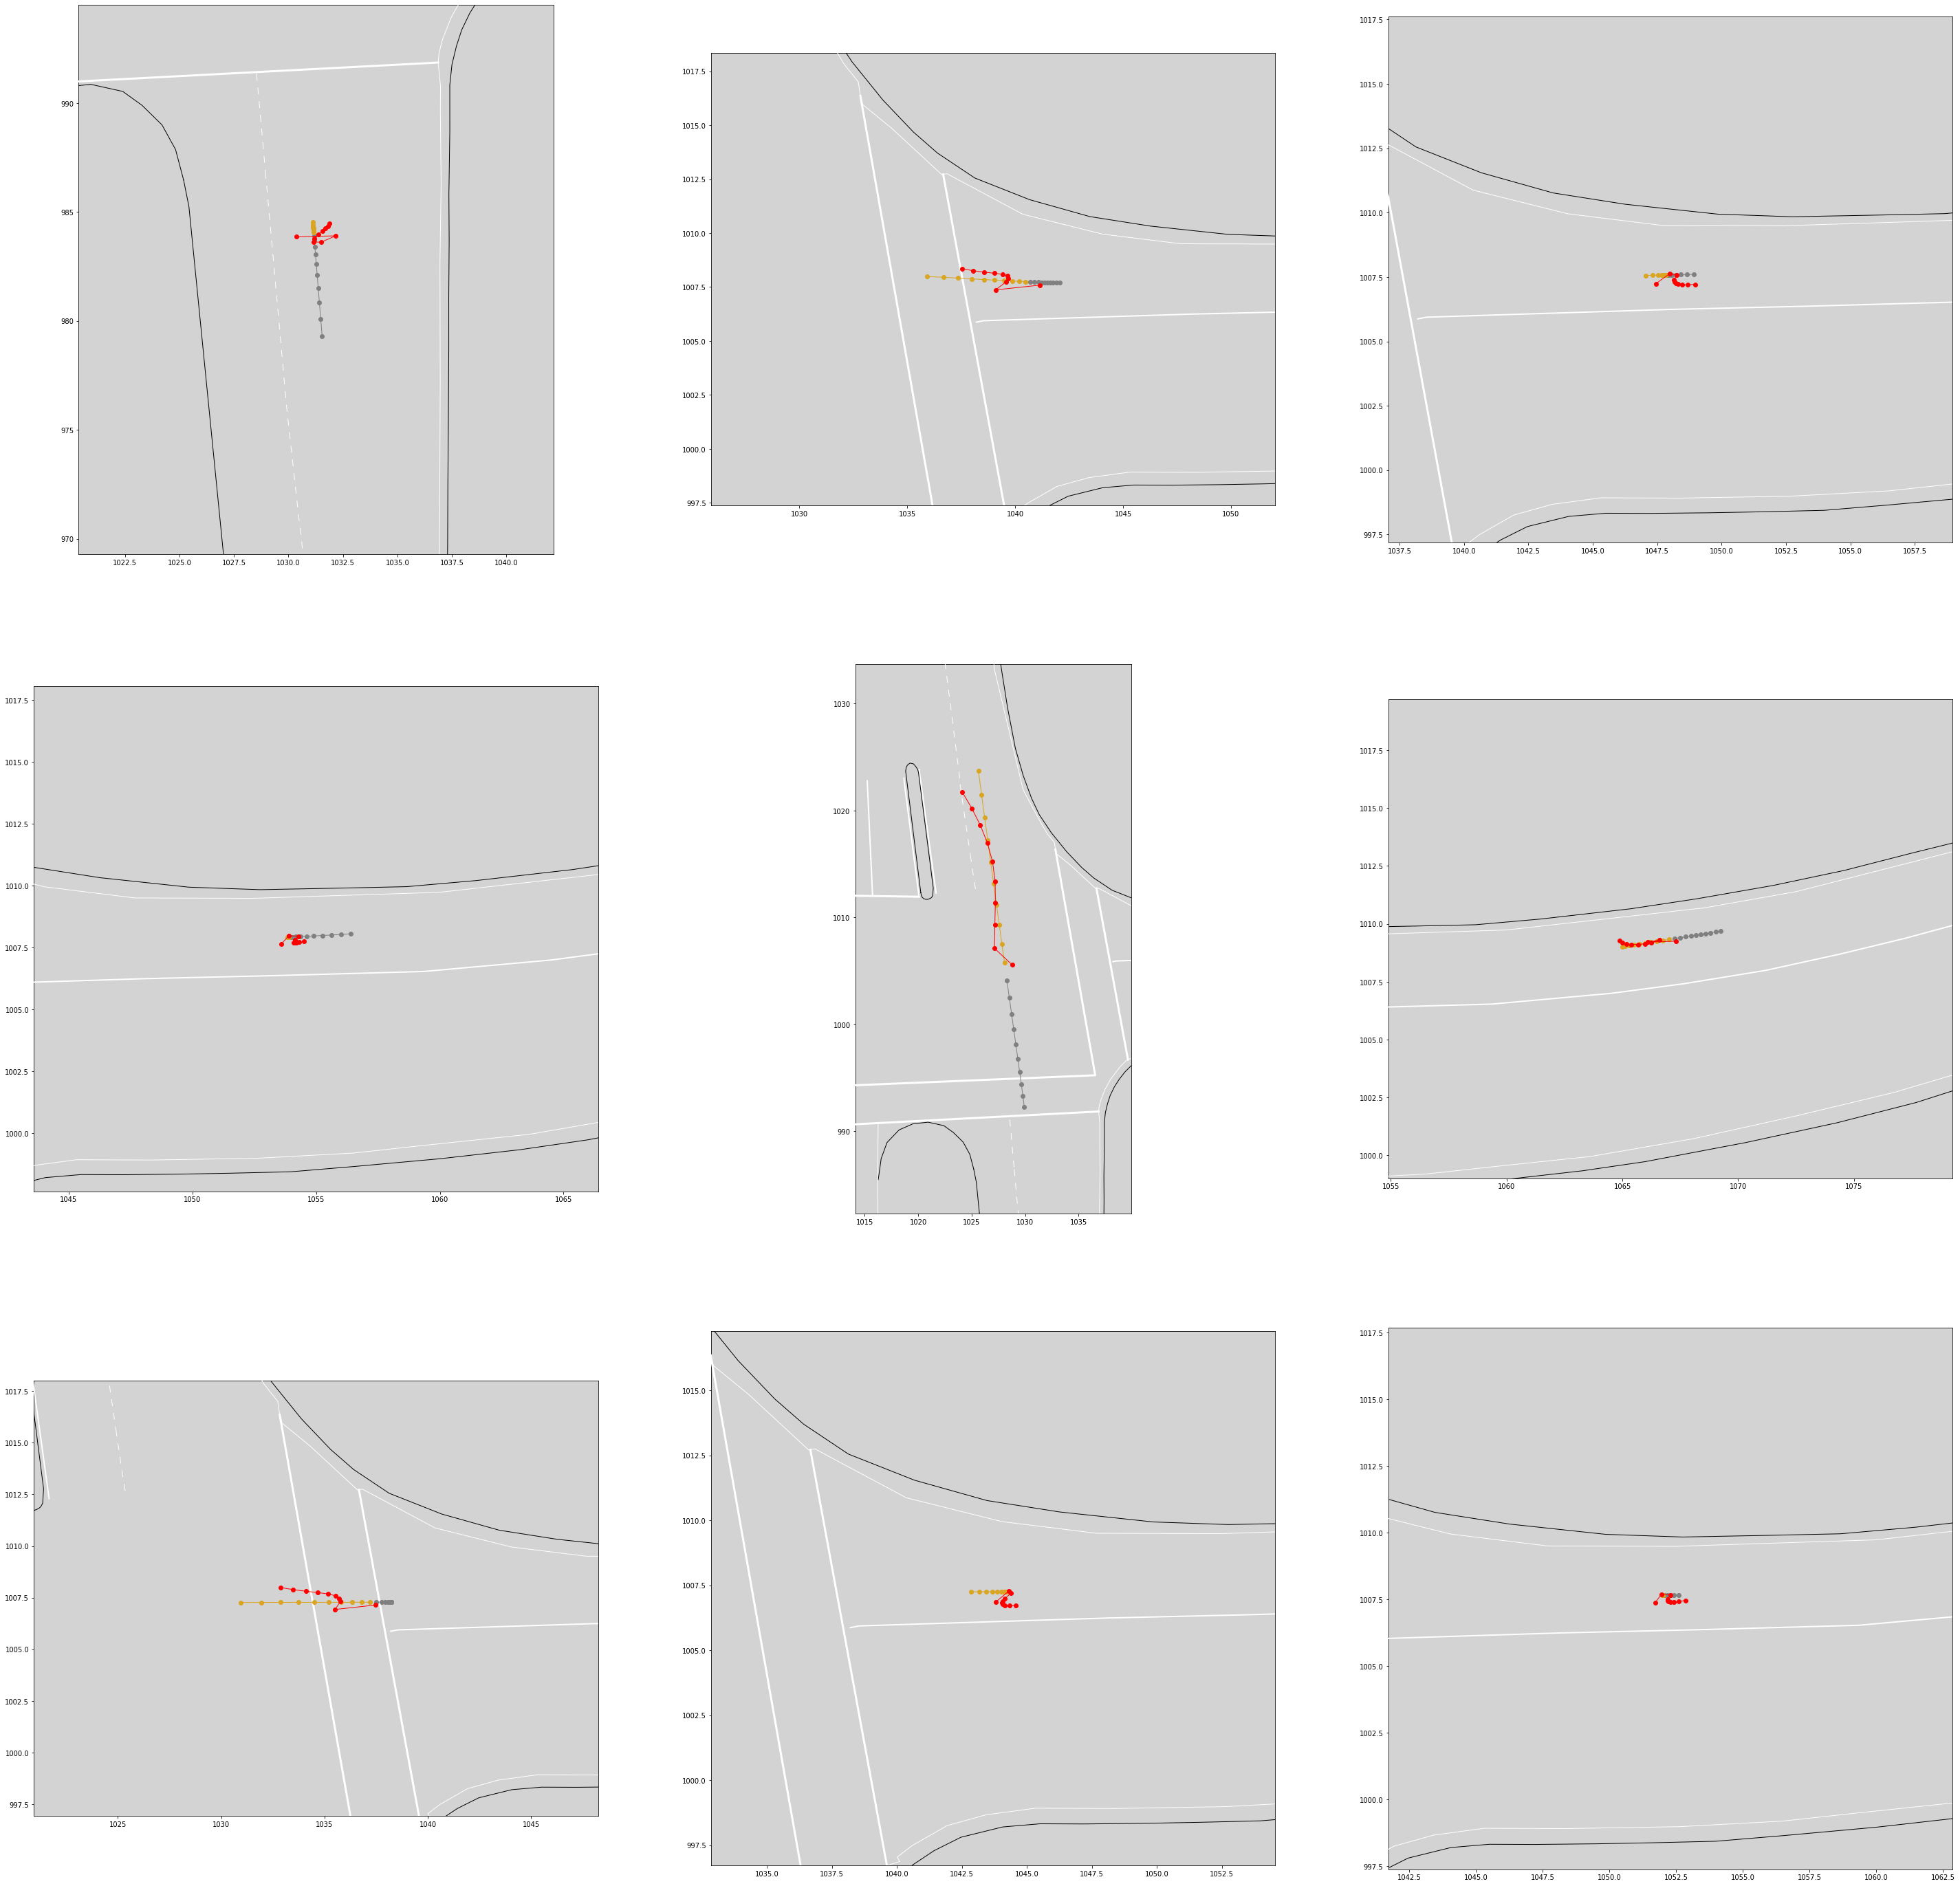

In [19]:
print_trajectory_set(x_test[:,:,:], y_test[:,:,:], results[:,:,:],0,show_map=True, zoom_map=True,debug=False)

In [23]:
#d = pd.read_csv(train_dataset_path, sep=',')
#d.drop(columns=['frame_id'],inplace=True)

#d.case_id = d.case_id.astype('int64')
#d.object_id = d.object_id.astype('int64')
#d.cluster_id = d.cluster_id.astype('int64')

#d.to_csv(csv_out_path + "sin_frame_id_train.csv",  index = False)
